# Replicates version 0.7 
Average (latent) feature values to generate synthetic samples
* Genetic averaging   
Begin synthetic sample curve at the end of the real curve - done    
Blend samples - done

## Experimental notes

In [1]:
from IPython.display import Image

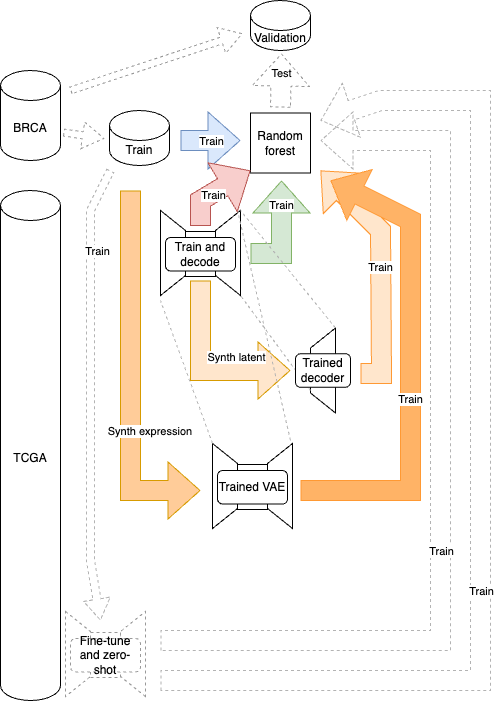

In [2]:
Image(filename='val_five.png', width = 500)

In [ ]:
# Latent dim, BRCA curve in v6 was 500
# Feature pruning threshold for mean abs dev (MAD) - currently 5k
# Subsetting on gene expression (GEXP)
# Removal of LGGGGBM
# Batch size, 50 and 10 for pre-train and fine-tune
# All the random forest stuff (like repeats), including the random forest itself
# RF retrain on same trn set returns a different result on the val set
# VAE architechture  - just swap in a transformer
# Retain class imbalance vs. add proportionaly more under-sampled class samples

In [ ]:
# need a reinfocement loop to automate experimental parameter search space

## Version set / Imports

In [1]:
v = 'rep_0.7' # Synth samples by average feature values
v

'rep_0.7'

In [ ]:
# HNSC, and LUAD
    # Learning curves
        # Challenge: each learning curve is generated from a single replication split
        # Solution sub-sample a small cancer at ~90% and blend the learning curves
    # Loss plots
    # Front-end box and running average - sig bars failed at replct count < 4
    
    # Take sample count down to 80 - 120 and test on HNSC and LUAD
    # Turn up synthetic sample count by an order of magnitude - done

In [4]:
ls i_o/rep_0.7/

In [6]:
mkdir i_o/rep_0.7/BRCA

In [52]:
mkdir i_o/rep_0.7/BRCA/decoded_objs

In [7]:
mkdir i_o/rep_0.7/BRCA/front_end_box

In [8]:
mkdir i_o/rep_0.7/BRCA/latent_objs

In [9]:
mkdir i_o/rep_0.7/BRCA/learn_curve

In [10]:
mkdir i_o/rep_0.7/BRCA/loss_plots

In [11]:
mkdir i_o/rep_0.7/BRCA/take-off_points

In [12]:
%whos

Variable   Type    Data/Info
----------------------------
v          str     rep_0.7


In [13]:
import seaborn as sns
import pandas as pd
import glob as glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from statistics import mean
from statistics import stdev
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Layer
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from matplotlib import rcParams 
from random import sample
from sklearn.metrics import accuracy_score
from statannot import add_stat_annotation

## VAE Setup

In [14]:
# Function set for leave one out loop
def compute_latent(x): # x: This function is argument one in the Lambda layer
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim), mean=0., stddev=1.0 )
    return mu + K.exp(sigma/2)*eps

# Set custom layer , will need all this at start of shell script
class CustomVariationalLayer(Layer):
    """
    Define a custom layer
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

## Data

### Read files

In [15]:
file_paths_no_LGGGGBM = sorted(
    glob.glob(
        'i_o/GEXP_MAD_5k_across_no_LGGGBM/*.tsv' # <---- LGGGBM excluded
    ))

In [9]:
file_paths_no_LGGGGBM[8]

'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRCKICH_across_5k_no_LGGGBM.tsv'

In [11]:
file_paths = sorted(
    glob.glob(
        'i_o/GEXP_MAD_5k_across/*.tsv' # <---- LGGGBM included
    ))

In [16]:
len(file_paths_no_LGGGGBM)

25

In [129]:
len(file_paths)

26

In [7]:
file_paths[8]

'i_o/GEXP_MAD_5k_across/KIRCKICH_across_5k.tsv'

In [6]:
file_paths

['i_o/GEXP_MAD_5k_across/ACC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BLCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BRCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/CESC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/COADREAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/ESCC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/GEA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/HNSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRCKICH_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRP_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LGGGBM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LIHCCHOL_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/MESO_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/OV_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PAAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PCPG_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PRAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SARC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SKCM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across

### Cohort sample counts

In [ ]:
len_list = []
for path in file_paths:
    file = pd.read_csv(path, sep = '\t', index_col = 0)
    len_list.append((file.index.name, len(file)))

In [10]:
len_list # KIRCKICH is third largest with 556 samples
        # HNSC has 506 for fourth
        # LUAD has an even 500 samples as the fifth most samples

[('ACC', 76),
 ('BLCA', 399),
 ('BRCA', 995),
 ('CESC', 177),
 ('COADREAD', 449),
 ('ESCC', 86),
 ('GEA', 461),
 ('HNSC', 506),
 ('KIRCKICH', 556),
 ('KIRP', 155),
 ('LGGGBM', 782),
 ('LIHCCHOL', 378),
 ('LUAD', 500),
 ('LUSC', 460),
 ('MESO', 74),
 ('OV', 285),
 ('PAAD', 76),
 ('PCPG', 159),
 ('PRAD', 273),
 ('SARC', 191),
 ('SKCM', 444),
 ('TGCT', 133),
 ('THCA', 486),
 ('THYM', 117),
 ('UCEC', 499),
 ('UVM', 74)]

### Pre-train setup

In [6]:
len(file_paths)

26

In [5]:
file_paths

['i_o/GEXP_MAD_5k_across/ACC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BLCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BRCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/CESC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/COADREAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/ESCC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/GEA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/HNSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRCKICH_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRP_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LGGGBM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LIHCCHOL_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/MESO_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/OV_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PAAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PCPG_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PRAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SARC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SKCM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across

In [12]:
TCGA_no_BRCA = ['i_o/GEXP_MAD_5k_across/ACC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BLCA_across_5k.tsv',
 # 'i_o/GEXP_MAD_5k_across/BRCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/CESC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/COADREAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/ESCC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/GEA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/HNSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRCKICH_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRP_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LGGGBM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LIHCCHOL_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/MESO_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/OV_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PAAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PCPG_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PRAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SARC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SKCM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/TGCT_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/THCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/THYM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/UCEC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/UVM_across_5k.tsv']

### No LGGGBM pre-train setup

In [21]:
file_paths_no_LGGGGBM

['i_o/GEXP_MAD_5k_across_no_LGGGBM/ACC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BLCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BRCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/CESC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/COADREAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/ESCC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/GEA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/HNSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRCKICH_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRP_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LIHCCHOL_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/MESO_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/OV_across_5k_no_LGGGBM.tsv',
 '

In [17]:
TCGA_less_LGGGGBM_no_BRCA = ['i_o/GEXP_MAD_5k_across_no_LGGGBM/ACC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BLCA_across_5k_no_LGGGBM.tsv',
 # 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BRCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/CESC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/COADREAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/ESCC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/GEA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/HNSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRCKICH_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRP_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LIHCCHOL_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/MESO_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/OV_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/PAAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/PCPG_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/PRAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/SARC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/SKCM_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/TGCT_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/THCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/THYM_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/UCEC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/UVM_across_5k_no_LGGGBM.tsv']

### Build an all-but-one TCGA dataframe

In [18]:
tall_stack = pd.DataFrame()
for path in TCGA_less_LGGGGBM_no_BRCA:
# for path in TCGA_no_BRCA:
    print(path)
    file = pd.read_csv(
    path, sep = '\t', index_col = 0)
    tall_stack = pd.concat( [tall_stack, file] ,
                           axis = 0)

i_o/GEXP_MAD_5k_across_no_LGGGBM/ACC_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/BLCA_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/CESC_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/COADREAD_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/ESCC_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/GEA_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/HNSC_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRCKICH_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRP_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/LIHCCHOL_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/LUAD_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/LUSC_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/MESO_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/OV_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/PAAD_across_5k_no_LGGGBM.tsv
i_o/GEXP_MAD_5k_across_no_LGGGBM/PCPG_across_5k_no_LGGGBM.tsv


In [19]:
tall_stack.shape # hold-out all of BRCA from TCGA less LGGGBM

(7014, 5001)

In [9]:
tall_stack.shape # hold-out all of BRCA

(7796, 5001)

In [20]:
tall_stack.head(1)

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
TCGA-OR-A5J1,ACC_2,0.000182,0.360981,0.001892,0.007364,0.0,0.0,0.0,0.000284,0.00609,...,0.246175,0.542221,0.402793,0.335923,0.241655,0.232638,0.13753,0.278195,0.306376,0.078349


In [21]:
pre_train_file = tall_stack

In [22]:
pre_train_file.shape

(7014, 5001)

In [15]:
pre_train_file.shape

(7796, 5001)

### Direct / fine-tune

In [23]:
fine_tune_file = pd.read_csv(
    file_paths_no_LGGGGBM[2], # BRCA for no LGGGGBM experimenrt
    sep = '\t', index_col = 0)
fine_tune_file.index.name

'BRCA'

In [16]:
fine_tune_file = pd.read_csv(
    file_paths[2], # BRCA from replicates 0.2
    sep = '\t', index_col = 0)
fine_tune_file.index.name

'BRCA'

In [10]:
fine_tune_file = pd.read_csv(
    file_paths_no_LGGGGBM[8], # KIRCKICH
    sep = '\t', index_col = 0)

In [ ]:
fine_tune_file = pd.read_csv(
    file_paths[10], # KIRCKICH
    sep = '\t', index_col = 0)

In [137]:
fine_tune_file

,Labels,N:GEXP::COL1A1:1277:,N:GEXP::TG:7038:,N:GEXP::FN1:2335:,N:GEXP::SERPINA1:5265:,N:GEXP::COL3A1:1281:,N:GEXP::COL1A2:1278:,N:GEXP::FTL:2512:,N:GEXP::GAPDH:2597:,N:GEXP::ACTB:60:,...,N:GEXP::DECR2:26063:,N:GEXP::ATPAF1:64756:,N:GEXP::TSPAN17:26262:,N:GEXP::TMEM50B:757:,N:GEXP::TMEM125:128218:,N:GEXP::NMD3:51068:,N:GEXP::HS2ST1:9653:,N:GEXP::CDH13:1012:,N:GEXP::C8orf30A:51236:,N:GEXP::SLC41A3:54946:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,BRCA_1,0.031385,0.009340,0.039359,0.046129,0.031442,0.018842,0.087729,0.089627,0.136415,...,0.134333,0.395323,0.211688,0.285639,0.233318,0.203803,0.242757,0.060273,0.172109,0.526240
TCGA-3C-AALI,BRCA_4,0.101237,0.030875,0.091098,0.028947,0.071486,0.053656,0.109263,0.248707,0.348832,...,0.221111,0.184540,0.200623,0.120528,0.247122,0.183697,0.128036,0.145553,0.177389,0.498367
TCGA-3C-AALJ,BRCA_2,0.102118,0.026908,0.102970,0.002073,0.069342,0.051479,0.181907,0.182647,0.358672,...,0.393196,0.162478,0.192225,0.105651,0.137341,0.162629,0.120194,0.104077,0.302681,0.230708
TCGA-3C-AALK,BRCA_1,0.245417,0.028296,0.116361,0.008146,0.195194,0.128708,0.090467,0.143409,0.321840,...,0.189172,0.163491,0.190177,0.158288,0.220929,0.145901,0.163564,0.111635,0.127003,0.270418
TCGA-4H-AAAK,BRCA_1,0.233795,0.015375,0.208902,0.004443,0.238647,0.162215,0.104993,0.140335,0.308237,...,0.115154,0.174519,0.152611,0.175450,0.228238,0.179946,0.223932,0.121891,0.173570,0.322601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44,BRCA_1,0.151985,0.008408,0.066331,0.001252,0.068486,0.067384,0.182326,0.130463,0.735460,...,0.549026,0.175498,0.160633,0.205027,0.163870,0.125576,0.083509,0.038011,0.147255,0.183957
TCGA-XX-A899,BRCA_1,0.115542,0.007113,0.087292,0.008191,0.131443,0.066699,0.097668,0.119608,0.313509,...,0.138364,0.151470,0.200950,0.204139,0.189732,0.175460,0.194509,0.100316,0.101179,0.274839
TCGA-XX-A89A,BRCA_1,0.254498,0.004876,0.150192,0.012612,0.259711,0.130643,0.217217,0.086321,0.361050,...,0.152896,0.155937,0.187217,0.139626,0.669949,0.182596,0.212924,0.099072,0.134256,0.239085


In [24]:
fine_tune_file.Labels.value_counts()

BRCA_1    535
BRCA_2    205
BRCA_3    175
BRCA_4     80
Name: Labels, dtype: int64

In [25]:
fine_tune_file.index.name

'BRCA'

### MSigDB setup

In [ ]:
# c2 is curated gene sets
# c4 is computational gene sets
# c6 is oncogenic gene sets
# c8 is cell type (is this interesting given the bulk sequencing nature of the expression data

#### MSigDB devel

In [55]:
with open('i_o/MSigDB/c2.all.v2022.1.Hs.symbols.gmt.txt') as gmt:
    print(gmt.read(3000))

SHARMA_ASTROCYTOMA_WITH_NF1_SYNDROM	http://www.gsea-msigdb.org/gsea/msigdb/human/geneset/SHARMA_ASTROCYTOMA_WITH_NF1_SYNDROM	ADGRV1	MAP3K7CL	CLEC3B	SLC1A3	STN1
LIU_OVARIAN_CANCER_TUMORS_AND_XENOGRAFTS_XDGS_UP	http://www.gsea-msigdb.org/gsea/msigdb/human/geneset/LIU_OVARIAN_CANCER_TUMORS_AND_XENOGRAFTS_XDGS_UP	RPLP0P11	PFN1P11	DSCAM-AS1	MT-TS2	FGB	MT-TL2	PAX2	FOXB1	MAGEC2	SLC28A2	LINC02593	CPLX2	MGAT5B	SBK2	LEMD1-DT	ANK1	EVPLL	TGM7	LCN10	ENSG00000262884	DISP3	SIAH3	IGSF23	RD3	MYOM3	MIR4664	NAT8L	ALPL	LINC01001	FOXI3	KCNH3	GRIN2B	XKR7	CELSR3	CICP27	RASSF10	LINC02108	SKIDA1	STAG3L3	FAR2P1	LINC01224	ID1	WDR62	CCDC150	PLEKHG4B	RBM25-AS1	STAG3L5P	KIF18B	ZDHHC8P1	DDX12P	MKRN3	GOLGA2P5	TUBA5P	ZNF114	LINC00319	MYBL2	UCA1	KSR2	CYSRT1	MIR1302-9HG	HASPIN	MKI67	CNGB1	MIR29B2CHG	GGT2P	CCNF	SNORD86	LY6G5B	FBN3	DUX4L27	RNFT2	ULBP3	MAP3K9	LINC01873	LINC01764	LINC00958	TROAP	PALM3	PIF1	OCLNP1	P2RY2	GPAT4-AS1	RAP1GAP2	ENSG00000260874	KIF12	PAX8-AS1	FAM215B	MT-TH	PROX2	CLSPN	LHX4	SULT1A3	DACT2	GPC1-AS1	LI

In [57]:
!pip3 install gsea_api

  Preparing metadata (setup.py) ... done
  Created wheel for gsea_api: filename=gsea_api-0.3.4-py3-none-any.whl size=16222 sha256=30b329bf5aefd824a4c97e0302b9a1d8a68920c5ef139cb7c2a9a82a3e3fede1
  Stored in directory: /Users/karlberb/Library/Caches/pip/wheels/56/15/35/fba801a64dbbeffa992988de38bcc17e110862d467a07136e1
Successfully built gsea_api


In [58]:
from gsea_api.molecular_signatures_db import GeneSets

In [72]:
!pip3 install gseapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.1/444.1 kB 7.8 MB/s eta 0:00:0000:01


In [73]:
import gseapy as gp

In [75]:
hlmrk = gp.read_gmt(path="i_o/MSigDB/c2.all.v2022.1.Hs.symbols.gmt")

In [ ]:
hlmrk.keys()

In [77]:
len(hlmrk)

6449

In [ ]:
pd.DataFrame(hlmrk)

## Validation setup

In [16]:
len (fine_tune_file) / 2

497.5

In [17]:
len (fine_tune_file)

995

In [139]:
len (fine_tune_file) * .25 # 25%

248.75

In [26]:
trn_size = 65 # End point of real data in learning curve
trn_size

65

In [ ]:
# Val means validation 

In [28]:
inpt_val = pd.DataFrame() # blue
lat_val = pd.DataFrame() # Turning this back on, red
dec_val = pd.DataFrame() # green
synth_lat_val = pd.DataFrame() # dark orange
synth_inpt_val = pd.DataFrame() # light orange
blend_inpt_synthFrmLat_val = pd.DataFrame()

In [27]:
del(tall_stack)
del(file)

In [31]:
# Two training files and five replicate results storage objects:

In [29]:
%whos DataFrame

Variable                     Type         Data/Info
---------------------------------------------------
blend_inpt_synthFrmLat_val   DataFrame    Empty DataFrame\nColumns: []\nIndex: []
dec_val                      DataFrame    Empty DataFrame\nColumns: []\nIndex: []
fine_tune_file               DataFrame                  Labels  N:G<...>[995 rows x 5001 columns]
inpt_val                     DataFrame    Empty DataFrame\nColumns: []\nIndex: []
lat_val                      DataFrame    Empty DataFrame\nColumns: []\nIndex: []
pre_train_file               DataFrame                 Labels  N:GE<...>7014 rows x 5001 columns]
synth_inpt_val               DataFrame    Empty DataFrame\nColumns: []\nIndex: []
synth_lat_val                DataFrame    Empty DataFrame\nColumns: []\nIndex: []


In [30]:
repeats = 10 # to all random forest validation runs

## Start Replicate run here <---  
toggle the validation split code

In [233]:
v # Check where all this stuff is gonna go

'rep_0.7'

In [278]:
val_split = 'vs05@'+str(trn_size) # Replicates TOGGLE <--- start at one
trn = fine_tune_file.sample(trn_size) # Build train and validation files from fine-tune
val = fine_tune_file.loc[fine_tune_file[~fine_tune_file.index.isin(trn.index)].index, :]
val_split

'vs05@65'

In [279]:
trn.shape

(65, 5001)

In [281]:
trn.Labels.value_counts()

BRCA_1    33
BRCA_3    15
BRCA_2    11
BRCA_4     6
Name: Labels, dtype: int64

In [280]:
val.shape

(930, 5001)

## Input validation plot

In [ ]:
pretrain_status = '_TCGA_'+number_of_training_epic_here+'_epochs' # Because its not complitcated enough already

In [282]:
print('Start input validation with RF')
val_inpt_acrcy_lst = []
val_inpt_running_average = []

X_trn = trn.iloc[:, 1:] # Train objects for RF
y_trn = trn.iloc[:, 0]
X_val = val.iloc[:, 1:] # Validation objects, checked above
y_val = val.iloc[:, 0]

for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('Half way to 10 rpts')    
    
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn) # Do not fit on val data
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val)) # <--- predict on validation set, important
    val_inpt_acrcy_lst.append(val_raw_acc) # Box plots
    val_inpt_running_average.append(mean(val_inpt_acrcy_lst))
inpt_val.insert(0, val_split, val_inpt_running_average)
print('Input transfer predictions complete')

Start input validation with RF
Half way to 10 rpts
Input transfer predictions complete


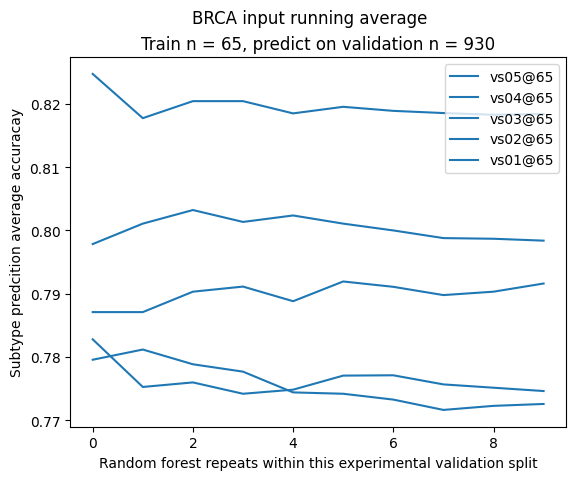

In [283]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
plt.suptitle(fine_tune_file.index.name + ' input running average')
plt.title('Train n = '+str(
    len(trn))+', predict on validation n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

### Box setup

In [39]:
inpt_val.iloc[repeats-1, :] # final row is most-updated average

vs01@65    0.772581
Name: 9, dtype: float64

In [101]:
inpt_val.iloc[9, :] # Original examaple of five replicates

vs05    0.902424
vs04    0.898586
vs03    0.872525
vs02    0.890707
vs01    0.883232
Name: 9, dtype: float64

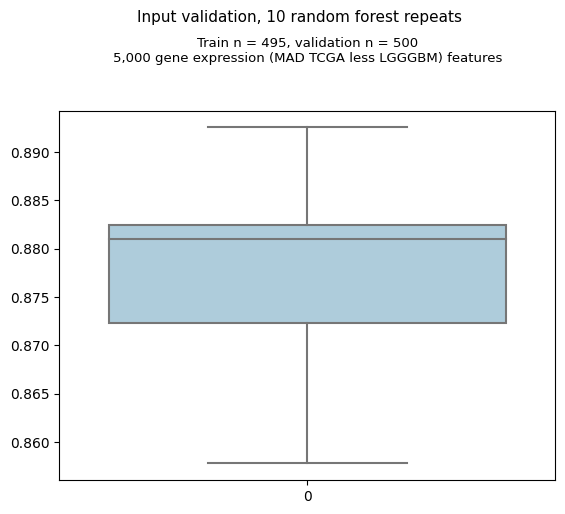

In [122]:
ax = sns.boxplot(inpt_val.iloc[9, :], # Most-updated average goes here
                 palette = [plt.cm.Paired(0)])
plt.suptitle('Input validation, '+str(repeats)+' random forest repeats',
             fontsize = 11, y = 1.09)
plt.title('Train n = '+str(
    len(val))+', validation n = '+str(
    len(trn))+'\n5,000 gene expression (MAD TCGA less LGGGBM) features',
          fontsize = 9.5, y = 1.11)

# add_stat_annotation(ax,
#                     data=input_val_frame,
#                     # x=x, y=y, order=order,
#                     box_pairs=[('Hold_in_raw_accuracy', 'Hold_out_raw_accuracy')],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=0)

plt.savefig(
    'i_o/'+v+'/input_val_'+str(trn_size)+'_'+val_split+'.png', bbox_inches = 'tight')

## VAE training

In [ ]:
# Train and direct decode

train_object = trn   # <---- *** Do not train the VAE ever on hold-out; encode with pre-trained? - yes
fit_on_plot_title = train_object.index.name + ' n = ' + str(len(trn))
fit_on_file_write = train_object.index.name + '_n_'+ str(len(trn))

pre_trn = 'NONE'
feature_set = 'mad_5k_acros_no_LGGGBM'

pre_train_epochs = 'NA'
fine_tune_epochs = 'NA'

features = train_object.columns[1:]

original_dim = len(features)
feature_dim = len(features)
latent_dim = 100 # Direct train and decode (no need to match between pre-train and fine-tune)

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(compute_latent, output_shape=(latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005
kappa = 1

beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

train_epochs = 200

fit_start = time.time()
history = vae.fit(train_object.iloc[:, 1:],
            epochs=train_epochs,
                  batch_size=50,
                  shuffle=True,
                  callbacks=[WarmUpCallback(beta, kappa)],
                  verbose=0
                  )
fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on_plot_title+' train', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(train_epochs)+' epochs'+
             '\n'+str(latent_dim)+' latent',
            xy = (.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 32
            )

plt.savefig(
    'i_o/'+v+'/fit.'+fit_on_file_write+'.epochs.'+str(train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+fine_tune_epochs+
    '_latent_dim.'+str(latent_dim)+'_'+
    feature_set+'_'+val_split+
    '.png', bbox_inches='tight')

encoder = Model(encoder_inputs, z_mean_encoded)
decoder_input = keras.Input(shape = (latent_dim, ))
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

y_df = train_object.Labels

decoded = pd.DataFrame(decoder.predict(encoder.predict(train_object.iloc[:, 1:])),
                       index = train_object.index, columns = train_object.iloc[:, 1:].columns)

latent_object = pd.DataFrame(encoder.predict(train_object.iloc[:, 1:]),
             index=train_object.index,
        )
latent_object.index.name = train_object.index.name
latent_object = pd.concat( [pd.DataFrame(y_df), latent_object] , axis =1)
latent_object.to_csv(
    'i_o/'+v+'/fit.'+fit_on_file_write+'.epochs.'+str(train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_latent_object_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')

decoded_labeled = pd.concat( [pd.DataFrame(y_df), decoded] , axis =1)
decoded_labeled.to_csv(
    'i_o/'+v+'/fit.'+fit_on_file_write+'.epochs.'+str(train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_decoded_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')

print('Train and decode with '+feature_set+' feature set experiment done')

## VAE Pre train and fine-tune

2023-01-04 17:40:14.529359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:40:14.609378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:40:14.697908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:40:14.912363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:40:14.997007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:40:15.045530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:40:18.180829: I tensorflow/core/grappler/optimizers/cust

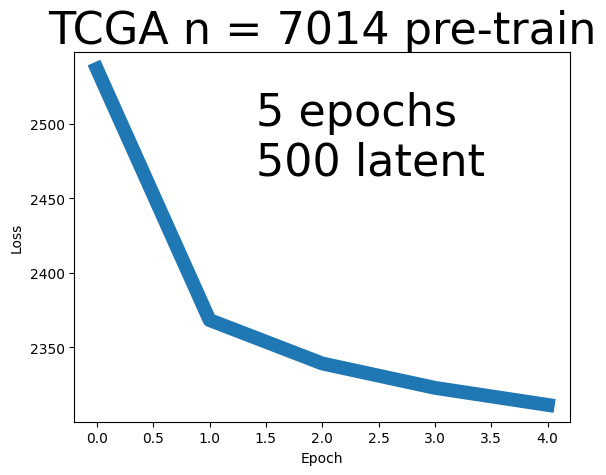

In [284]:
# Pre-train fitting with MAD 5k taken across all cancers

train_file = pre_train_file
fit_on_plot_title = 'TCGA n = ' + str(len(pre_train_file))
fit_on_file_write = 'TCGA_n_'+ str(len(pre_train_file))
pre_trn = 'NONE'
feature_set = 'mad_5k_across'

fine_tune_epochs = 'NA'

features = train_file.columns[1:] # Train file toggled above

original_dim = len(features)
feature_dim = len(features)
latent_dim = 500               # Toggle to plot labels <--- Latent feature set diminsionality       *******
batch_size = 50

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(compute_latent, output_shape=(latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005 # test this

kappa = 1
beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta]) # Take-off point from pre-training to fine-tuning

pre_train_epochs = 5

fit_start = time.time()
history = vae.fit(train_file.iloc[:, 1:],  #  fit the VAE on object, toggled in the setup
            epochs=pre_train_epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  callbacks=[WarmUpCallback(beta, kappa)],
                  verbose=0 #  <---------------------- turn this on for production *************
                  )
fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on_plot_title+' pre-train', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(pre_train_epochs)+' epochs'+
             '\n'+str(latent_dim)+' latent',
            xy = (.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 32
            )

# plt.legend(loc="lower left")
plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/loss_plots/fit.'+fit_on_file_write+'_epochs.'+str(pre_train_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+fine_tune_epochs+
    '_latent_dim.'+str(latent_dim)+'_'+ # Do not change latent dim in the middle of transfer training
    # '_pltv-'+str(plt_v)+
    # 'fitting_epochs.'+str(epochs)+'_'+
    feature_set+'_'+val_split+
    '.png', bbox_inches='tight')

/Users/karlberb/miniforge3/envs/tf_M1_py3dot9/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-01-04 17:41:01.045555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:41:01.172292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fine tuning with mad_5k_across feature set experiment done


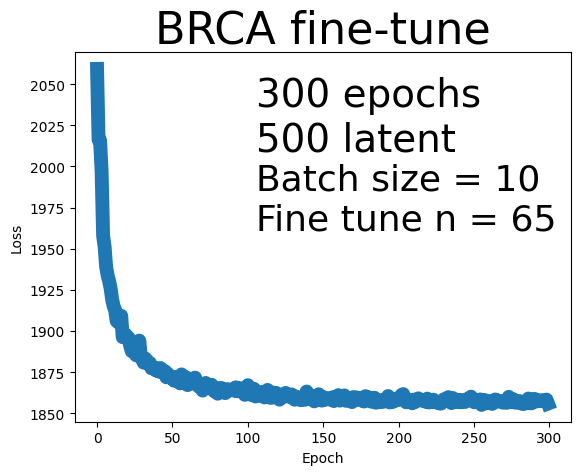

In [285]:
# Fine-tuning
# pretrain epochs variable in memory from above, latent dim also set already at this point

train_file = trn
pre_trn = fit_on_file_write
fit_on = trn.index.name

fine_tune_epochs = 300 # Overwrite 'NA' for this variable, from above; fine-tuning easy: 100, hard: 200
batch_size = 10

fit_start = time.time()
history = vae.fit(train_file.iloc[:, 1:],  #  fit the VAE on object, toggled in the setup
            epochs = fine_tune_epochs, batch_size=batch_size, shuffle=True,
            callbacks = [WarmUpCallback(beta, kappa)],
                 verbose=0 #  <---------------------- turn this on for production *************
                 )

fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on+' fine-tune', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(fine_tune_epochs)+' epochs'+
            '\n'+str(latent_dim)+' latent',     
            xy = (.4, .83), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 28
            )
plt.annotate('Batch size = '+str(batch_size)+
            '\nFine tune n = '+str(trn.shape[0]),             
            xy = (.4, .65), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 26
            )

# plt.legend(loc="lower left")
plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/loss_plots/fit.'+fit_on+'_epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+str(pre_train_epochs)+
    '_latent_dim.'+str(latent_dim)+'_'+ # Do not change latent dim in the middle of transfer training
    # '_pltv-'+str(plt_v)+
    # 'fitting_epochs.'+str(epochs)+'_'+
    feature_set+'_'+val_split+
    '.png', bbox_inches='tight') # version 18, norm within cohort
# plt.close()

encoder = Model(encoder_inputs, z_mean_encoded)
decoder_input = keras.Input(shape = (latent_dim, ))
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

y_df = train_file.Labels

decoded = pd.DataFrame(decoder.predict(encoder.predict(train_file.iloc[:, 1:])), # rep v.7 checks, run the training samples throught the model
                       index = train_file.index, columns = train_file.iloc[:, 1:].columns)

latent_object = pd.DataFrame(encoder.predict(train_file.iloc[:, 1:]),
             index=train_file.index,
                # columns=decode_df.iloc[:, 1:].columns # Columns are different because this is latent space
        )
latent_object.index.name = trn.index.name
latent_object = pd.concat( [pd.DataFrame(y_df), latent_object] , axis =1)
latent_object.to_csv(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/latent_objs/fit.'+fit_on+'_epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+str(pre_train_epochs)+
    '_latent_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')
# break
decoded_labeled = pd.concat( [pd.DataFrame(y_df), decoded] , axis =1)
decoded_labeled.to_csv(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/decoded_objs/fit.'+fit_on+'_epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'_epochs.'+str(pre_train_epochs)+
    '_decoded_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')

print('Fine tuning with '+feature_set+' feature set experiment done')

## Latent plus input validation plot
Red curve on plot, keep for explaining how the synthetic latent curve is derived

In [ ]:
# Get the encoder
    # Held-out validation set must have same feature space to run a test on
    # This means a train-set trained encoder is required

In [ ]:
# Encoder in memory trained on trn set

In [57]:
val.shape

(930, 5001)

In [286]:
val_encoded = pd.DataFrame(encoder.predict( # Sample count does not match here, this is the whole point
    val.iloc[:, 1:]),
        index = val.index)
val_encoded_labeled = pd.concat(
    [pd.DataFrame(val.Labels),
     val_encoded] , axis =1)

In [59]:
val_encoded_labeled.shape # predict on with random forest

(930, 501)

In [287]:
# Latent to random forest
print('Latent validation start')
X_trn = latent_object.iloc[:, 1:] # Now train on dimensionally reduced latent feature set, is latent_obj written out? A: yes
y_trn = latent_object.iloc[:, 0]
X_val = val_encoded_labeled.iloc[:, 1:] # Predict on the held-out validation set dimensionally reduced with the trained encoder
y_val = val_encoded_labeled.iloc[:, 0] 
val_lat_raw_acc_lst = []
val_lat_running_average = []
for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('five done')   
    
    clf_trn = RandomForestClassifier() # Leave in loop to reinitialie each time through
    clf_trn.fit(X_trn, y_trn)
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    val_lat_raw_acc_lst.append(val_raw_acc) # Box plots
    val_lat_running_average.append(mean(val_lat_raw_acc_lst))
lat_val.insert(0, val_split, val_lat_running_average)
print('Latent validation complete')

Latent validation start
five done
Latent validation complete


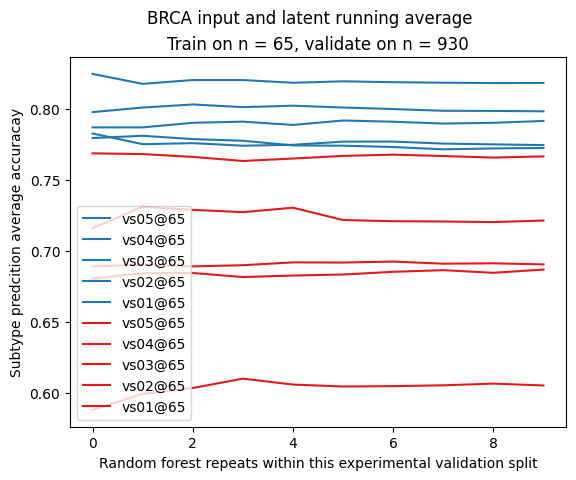

In [288]:
# Latent vs. input front-end plot, zoom in on running average withing each experimental replicate, eventually summarize with front-end box
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run) 
plt.suptitle(fine_tune_file.index.name + ' input and latent running average')
plt.title('Train on n = '+str(
    len(trn))+', validate on n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

## Decoded plus latent and input validation plot

### Decoded read
Skip, looks sketchy  
Encoding and decoding validation with pre-trained and fine-tuned VAE (?)

In [28]:
dec_pths = sorted(glob.glob('i_o/'+v+'/fit.BRCA*decoded*'+val_split+'.tsv'))
for pth in dec_pths:
    print(pth)

i_o/rep_0.2/fit.BRCA_n_500.epochs.100_pre_trained_on.NONE.epochs.NA_decoded_obj_latent_dim.100_mad_5k_acros_no_LGGGBM_vs05.tsv


In [29]:
trn_dec = pd.read_csv(dec_pths[0], sep = '\t', index_col = 0)

In [83]:
# Take trained encoder and decoder
val_decoded = pd.DataFrame(decoder.predict(encoder.predict(val.iloc[:, 1:])),
                       index = val.index, columns = val.iloc[:, 1:].columns)
val_decoded = pd.concat([val.iloc[:, 0], val_decoded], axis = 1)

In [30]:
trn_dec.shape

(500, 5001)

In [31]:
trn_dec.head(1)

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-A8-A09X,BRCA_4,0.003137,0.013563,0.061969,0.092185,0.007884,0.004684,0.003019,0.037026,0.013034,...,0.232048,0.22575,0.228447,0.29598,0.176973,0.306326,0.058374,0.112701,0.204532,0.059944


In [49]:
trn.shape

(500, 5001)

In [64]:
decoded.shape

(500, 5000)

In [63]:
decoded.head()

,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,N:GEXP::COL3A1:1281:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-A7-A13D,0.002353,0.018010,0.062597,0.117161,0.017180,0.014154,0.005973,0.017555,0.010403,0.058465,...,0.191479,0.299758,0.266679,0.259236,0.198943,0.173241,0.052870,0.247713,0.220081,0.034433
TCGA-GM-A3XL,0.004964,0.021274,0.021269,0.018225,0.032881,0.018695,0.005968,0.052340,0.015641,0.014670,...,0.206485,0.247038,0.221629,0.317675,0.129157,0.198371,0.102481,0.209865,0.270690,0.044581
TCGA-BH-A0HK,0.005326,0.017052,0.046896,0.031595,0.007599,0.006162,0.002974,0.027671,0.037927,0.047696,...,0.186005,0.271280,0.245825,0.234924,0.194128,0.305991,0.123260,0.133700,0.216746,0.186961
TCGA-OL-A5RZ,0.002251,0.006327,0.034850,0.019941,0.005286,0.003774,0.001554,0.018486,0.009993,0.022525,...,0.193584,0.141123,0.170473,0.146038,0.136338,0.126107,0.107549,0.177831,0.260399,0.026152
TCGA-E9-A2JT,0.002698,0.011741,0.051762,0.024436,0.007585,0.003085,0.001496,0.111770,0.007221,0.056780,...,0.106994,0.554489,0.196509,0.260815,0.239161,0.133773,0.116186,0.093351,0.143952,0.126408


In [65]:
trn.head()

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-3C-AALI,BRCA_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-3C-AALJ,BRCA_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-4H-AAAK,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-5L-AAT0,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
val = fine_tune_file.loc[fine_tune_file[~fine_tune_file.index.isin(trn.index)].index, :]

In [32]:
val.shape

(495, 5001)

In [59]:
val.iloc[:, 0]

BRCA
TCGA-3C-AAAU    BRCA_1
TCGA-3C-AALI    BRCA_4
TCGA-3C-AALJ    BRCA_2
TCGA-4H-AAAK    BRCA_1
TCGA-5L-AAT0    BRCA_1
                 ...  
TCGA-WT-AB44    BRCA_1
TCGA-XX-A899    BRCA_1
TCGA-XX-A89A    BRCA_1
TCGA-Z7-A8R5    BRCA_1
TCGA-Z7-A8R6    BRCA_2
Name: Labels, Length: 495, dtype: object

In [58]:
trn.head(1)

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
pd.concat([trn.iloc[:, 0], decoded], axis = 1)

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-3C-AALI,BRCA_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-3C-AALJ,BRCA_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-4H-AAAK,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-5L-AAT0,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AR-A5QP,NaN,0.005507,0.009834,0.083893,0.048489,0.008462,0.006432,0.003073,0.019792,0.017247,...,0.174312,0.171335,0.246070,0.178212,0.124749,0.196892,0.164214,0.162688,0.218777,0.095723
TCGA-BH-A0B4,NaN,0.005402,0.009590,0.109960,0.096573,0.004391,0.003667,0.002310,0.023308,0.008739,...,0.191087,0.169245,0.297067,0.192404,0.112897,0.249510,0.099726,0.130614,0.163762,0.064491
TCGA-GM-A2DA,NaN,0.004025,0.011523,0.108560,0.056969,0.006805,0.004726,0.002945,0.054792,0.015296,...,0.190215,0.246854,0.230126,0.185327,0.127035,0.189461,0.126024,0.113680,0.208588,0.107066


### Decoded_labled object in memory

In [65]:
decoded_labeled.shape

(65, 5001)

In [66]:
val.shape

(930, 5001)

In [289]:
# Validate with train on decoded
print('Decoded validation start')
X_trn = decoded_labeled.iloc[:, 1:] # Train on full set of decoded samples that were used to train the VAE
y_trn = decoded_labeled.iloc[:, 0]
X_val = val.iloc[:, 1:]             # Predict on validation
y_val = val.iloc[:, 0]   

val_dec_raw_acc_lst = []
val_dec_running_average = []

for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('half done') 
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    val_dec_raw_acc_lst.append(val_raw_acc) # Box plots
    val_dec_running_average.append(mean(val_dec_raw_acc_lst))
dec_val.insert(0, val_split, val_dec_running_average)
print('Decoded validation complete')

Decoded validation start
half done
Decoded validation complete


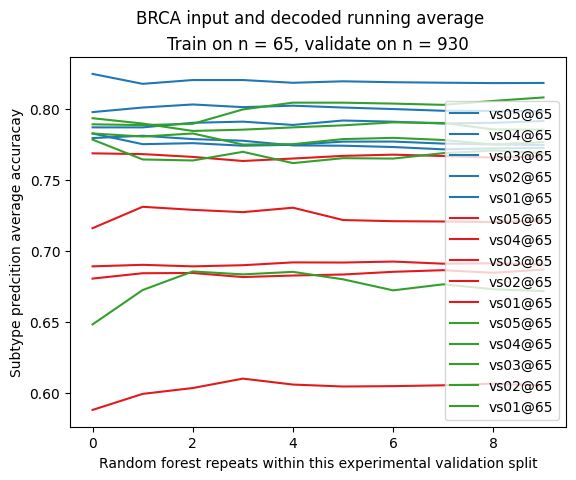

In [290]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)    
for run in dec_val.columns:
    plt.plot(dec_val[run], color = plt.cm.Paired(3), label = run)
plt.suptitle(fine_tune_file.index.name + ' input and decoded running average')
plt.title('Train on n = '+str(
    len(trn))+', validate on n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent+decoded_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

In [ ]:
# auto jitter labels with y value subtraction / addition based on final values (?) - no

## Synth main
Sythesize on latent and send to decoder  
Then train-on this decoded synth lat set and finally predict validation set that has not gone to VAE at all.

In [70]:
latent_object.shape

(65, 501)

In [ ]:
# Experimental question - how to automate balancing of subtype
# sample counts?

# A: 

In [243]:
trn.Labels.value_counts().max() # apply max sample count to each subtype

34

In [291]:
synth_ndx_strt = 0
synth_full_frame = pd.DataFrame(columns = latent_object.columns)

for subtype in sorted(latent_object.Labels.unique()): # Get each subtype from the latent-feature frame    
    print(subtype)
    sub = latent_object[latent_object.Labels == subtype] # Subset latent object by subtype
    synth_lat_feat_vec = [] # Blank list for synthetic latent feature vector
    synth_sub_len = len(sub)*5  # <------ Toggle the integer to set the sample size
    print(synth_sub_len)
    synth_index = ['SYNTH-' + fine_tune_file.index.name + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_sub_len + synth_ndx_strt))]]
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    
    synth_dict = {}
    for synth_sample in synth_sub_frame.index:
        pair = sub.sample(2)
        new_samp_vec = []
        for col in pair.iloc[:, 1:]:
            val_pair = pair.loc[:, col]
            choosen_val = val_pair.sample(1)
            new_samp_vec.append(choosen_val.values[0])

        synth_dict[synth_sample] = new_samp_vec
    synth_sub_frame = pd.concat([synth_sub_frame, pd.DataFrame(synth_dict).T], axis = 1)

    synth_full_frame = pd.concat(
        [synth_full_frame, synth_sub_frame], axis = 0) 
    
    synth_ndx_strt = synth_ndx_strt + synth_sub_len
print('Synth from latent, '+str(synth_sub_len)+' times each subtype sample count')

BRCA_1
165
BRCA_2
55
BRCA_3
75
BRCA_4
30
Synth from latent, 30 times each subtype sample count


### Decode synthetic generated from latent

In [292]:
synth_lat_dec = pd.concat([synth_full_frame.iloc[:, 0],
                       pd.DataFrame(decoder.predict(synth_full_frame.iloc[:, 1:]), index = synth_full_frame.index)],
                     axis = 1)
synth_lat_dec.columns = trn.columns

In [297]:
synth_lat_dec.Labels.value_counts()

BRCA_1    165
BRCA_3     75
BRCA_2     55
BRCA_4     30
Name: Labels, dtype: int64

In [293]:
# Validate synthetic: train on synthetic latent decoded, predict on validation

print('Synth latent validation start')
X_trn = synth_lat_dec.iloc[:, 1:] # Train on decoded synthetic latent
y_trn = synth_lat_dec.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]   

synth_lat_raw_acc_lst = []
synth_lat_running_average = []

for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('half')
    
    clf_trn = RandomForestClassifier() # Initialize classifier
    clf_trn.fit(X_trn, y_trn)
    synth_lat_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    synth_lat_raw_acc_lst.append(synth_lat_raw_acc) # Box plots
    synth_lat_running_average.append(mean(synth_lat_raw_acc_lst))
synth_lat_val.insert(0, val_split, synth_lat_running_average)
print('Synth latent complete')

Synth latent validation start
half
Synth latent complete


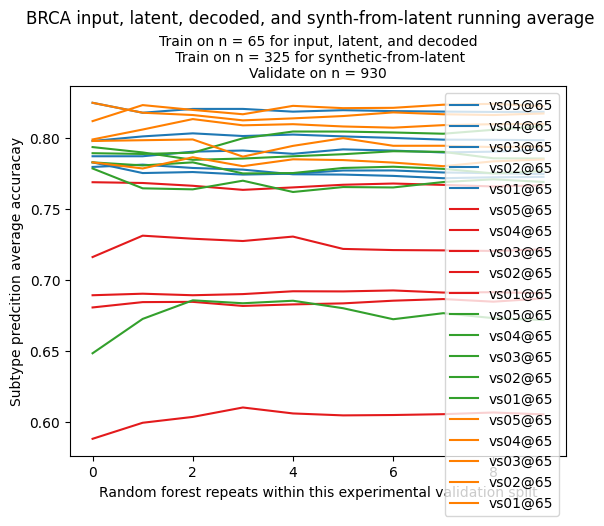

In [296]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)    
for run in dec_val.columns:
    plt.plot(dec_val[run], color = plt.cm.Paired(3), label = run)
for run in synth_lat_val.columns:
    plt.plot(synth_lat_val[run], color = plt.cm.Paired(7), label = run)
plt.suptitle(fine_tune_file.index.name + ' input, latent, decoded, and synth-from-latent running average',
            y = 1.04)
plt.title('Train on n = '+str(
    len(trn))+' for input, latent, and decoded'+
          '\n Train on n = '+str(len(synth_lat_dec))+' for synthetic-from-latent'
          '\nValidate on n = '+str(
    len(val)), size = 10)
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent+decoded+synthLat_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

## Synth devel

### Heatmaps on latent

<AxesSubplot: ylabel='BRCA'>

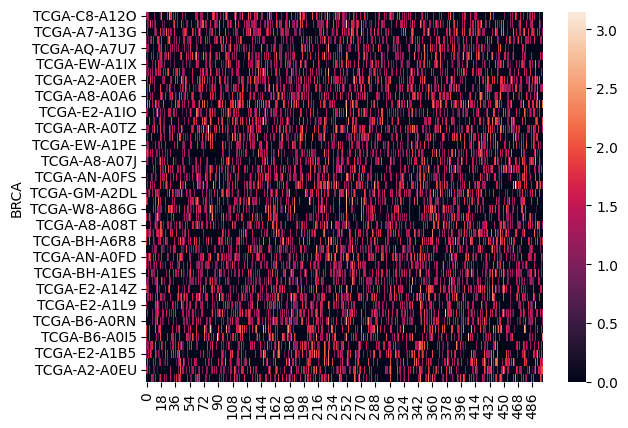

In [70]:
sns.heatmap(sub.iloc[:, 1:])

In [74]:
latent_object.shape

(75, 501)

In [78]:
latent_object.Labels.value_counts()

BRCA_1    46
BRCA_3    15
BRCA_2    10
BRCA_4     4
Name: Labels, dtype: int64

In [79]:
latent_object.sort_values('Labels')

,Labels,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-C8-A12O,BRCA_1,1.359787,1.544634,1.160278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.247231,0.000000,0.000000,1.051535,0.000000
TCGA-BH-A0H5,BRCA_1,1.365837,1.940515,1.138223,0.000000,0.000000,1.447489,0.109523,1.463198,0.122723,...,2.095377,0.000000,0.894778,0.000000,0.000000,1.385735,0.000000,0.000000,0.000000,0.000000
TCGA-A8-A07J,BRCA_1,1.088414,1.094643,0.297224,0.000000,0.000000,0.000000,0.000000,0.808251,0.000000,...,2.397464,0.000000,0.176821,0.000000,0.000000,1.766049,0.351184,0.000000,0.000000,0.000000
TCGA-AN-A0XT,BRCA_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.681231,...,1.076474,0.000000,0.000000,0.000000,1.007974,1.773632,0.000000,1.580521,0.000000,0.000000
TCGA-AN-A0FS,BRCA_1,0.000000,0.497157,0.000000,0.000000,0.000000,0.000000,1.513838,0.688932,0.000000,...,1.877466,0.000000,0.000000,0.596801,0.000000,1.658329,0.000000,0.000000,0.000000,0.034639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AO-A129,BRCA_3,1.372960,0.000000,0.000000,1.564943,1.968471,2.061281,1.593511,0.000000,1.906960,...,0.000000,1.920189,1.736309,0.000000,1.880077,0.000000,0.000000,0.000000,1.657222,1.843730
TCGA-C8-A12P,BRCA_4,1.611132,0.000000,0.474292,0.000000,0.000000,0.000000,1.917726,0.000000,0.000000,...,0.000000,1.968924,0.000000,0.000000,1.599100,1.615421,1.319850,0.000000,0.000000,0.000000
TCGA-OL-A5RZ,BRCA_4,0.000000,0.000000,0.000000,1.853735,1.871265,0.000000,0.000000,0.000000,1.657832,...,0.000000,1.622831,1.707392,0.000000,0.000000,0.000000,1.465858,1.857623,0.000000,0.162194


<AxesSubplot: ylabel='BRCA'>

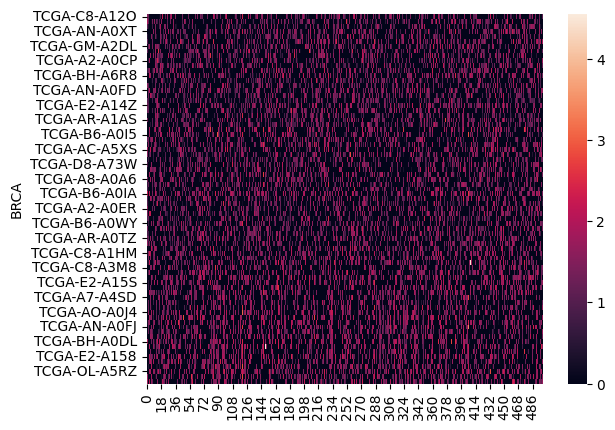

In [73]:
sns.heatmap(latent_object.sort_values('Labels').iloc[:, 1:])

### Averaging devel

In [103]:
len(synth_index)

460

In [ ]:
# Test both preserving the subtype ratios and balancing the subtype sample counts
    # how - Start with preserving

In [ ]:
for subtype_specific_synthetic_sample in list(range(0, len(max(sample_counts in subs)))):
    # Need to integrate with the synthetic index method

In [87]:
sub.shape

(46, 501)

In [98]:
for sample in sub.index:
    print(sample)
    pair = sub.sample(2)
    
    new_samp_vec = []
    for col in pair.iloc[:, 1:]:
        # print(col)
        val_pair = pair.loc[:, col]
        # print(val_pair)
        choosen_val = val_pair.sample(1)
        new_samp_vec.append(choosen_val)
        # break
    break

TCGA-C8-A12O


In [101]:
sub.shape

(46, 501)

In [100]:
sample

'TCGA-C8-A12O'

In [99]:
len(new_samp_vec) # The length equals the latent feature dim

500

In [96]:
choosen_val

BRCA
TCGA-AN-A0XT    0.0
Name: 0, dtype: float32

In [90]:
pair

,Labels,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-OL-A66L,BRCA_1,1.795622,0.000000,0.0,1.831326,0.000000,0.000000,0.0,0.000000,0.0,...,1.039193,0.000000,1.614857,1.592037,0.0,0.0,0.0,1.568509,0.0,0.0
TCGA-A8-A0A6,BRCA_1,0.000000,1.448647,0.0,0.000000,1.853933,1.215942,0.0,1.427067,0.0,...,0.000000,0.979023,2.311833,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
sub.sample(2)

In [64]:
for lat_feat in sub.columns[1:]: # Go through the subtype latent feature set,
    lat_col = sub.loc[:, lat_feat] # Pull each feature column
    break

### Latent feature histograms

<AxesSubplot: >

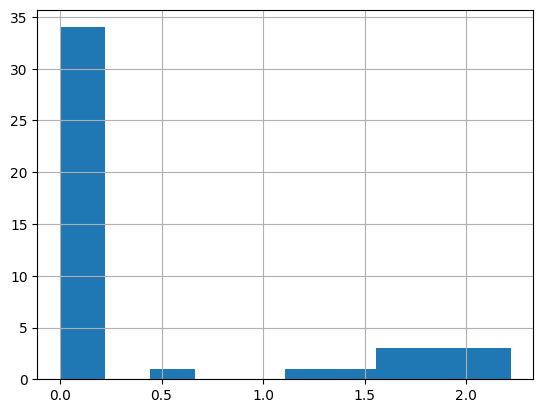

In [83]:
sub.loc[:, sub.columns[5]].hist()

<AxesSubplot: >

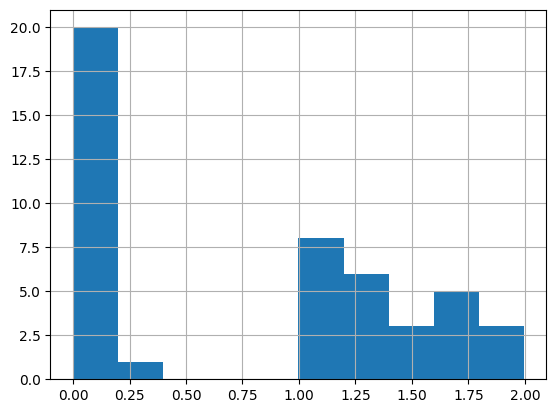

In [77]:
lat_col.hist()

### Averaging devel (cont)

In [76]:
sub.sample(2)

,Labels,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-E2-A14Z,BRCA_1,1.995601,1.349073,1.003980,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.546634,1.599369,0.000000,0.0
TCGA-E2-A1IO,BRCA_1,1.330277,0.991334,0.153136,0.0,0.0,0.0,0.0,0.0,1.262748,...,0.0,0.0,0.522742,1.161926,0.0,1.634951,0.000000,0.000000,0.696204,0.0


In [43]:
val.Labels.value_counts()

BRCA_1    500
BRCA_2    194
BRCA_3    164
BRCA_4     72
Name: Labels, dtype: int64

In [44]:
synth_full_frame.head(1)

,Labels,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,BRCA_1,0.0,0.636113,0.648427,0.0,1.515362,0.0,0.0,0.011639,1.311347,...,0.0,0.016305,0.0,0.990681,0.163472,1.333336,0.011997,1.013631,0.023723,0.0


## Synthetic input

In [298]:
synth_ndx_strt = 0
synth_inpt_frame = pd.DataFrame(columns = trn.columns)

for subtype in sorted(trn.Labels.unique()):
    print(subtype)
    sub = trn[trn.Labels == subtype]
    synth_sub_len = len(sub)*5  # <------ Toggle the integer to set the sample size
    print(synth_sub_len)
    synth_index = ['SYNTH-' + fine_tune_file.index.name + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_sub_len + synth_ndx_strt))]]
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    
    synth_dict = {}
    for synth_sample in synth_sub_frame.index:
        pair = sub.sample(2)
        new_samp_vec = []
        for col in pair.iloc[:, 1:]:
            val_pair = pair.loc[:, col]
            choosen_val = val_pair.sample(1)
            new_samp_vec.append(choosen_val.values[0])

        synth_dict[synth_sample] = new_samp_vec
        
    # break    
    synth_sub_frame = pd.concat(
        [synth_sub_frame, pd.DataFrame(
            synth_dict, index = trn.columns[1:]).T], axis = 1)

    synth_inpt_frame = pd.concat(
        [synth_inpt_frame, synth_sub_frame], axis = 0) 
    
    synth_ndx_strt = synth_ndx_strt + synth_sub_len
print('Synth '+str(synth_sub_len)+' times each subtype sample')

BRCA_1
165
BRCA_2
55
BRCA_3
75
BRCA_4
30
Synth 30 times each subtype sample


In [251]:
synth_inpt_frame.Labels.value_counts()

BRCA_1    170
BRCA_2     65
BRCA_3     55
BRCA_4     35
Name: Labels, dtype: int64

In [252]:
170/5

34.0

In [ ]:
# replicates balanced (rep_bal) version 0 [start]

In [ ]:
# Continue
# Remove labels, encode and decode with trained VAE, reinstall labels

In [299]:
synth_input_decoded = pd.DataFrame(decoder.predict(encoder.predict(synth_inpt_frame.iloc[:, 1:])),
                       index = synth_inpt_frame.index, columns = synth_inpt_frame.iloc[:, 1:].columns)
synth_input_decoded = pd.concat([synth_inpt_frame.iloc[:, 0], synth_input_decoded], axis = 1)
synth_input_decoded.columns = fine_tune_file.columns

In [300]:
# Synthetic samples from input val
print('Start synth input accuracy')
synth_input_raw_acc_lst = []
synth_input_running_average = []
X_trn = synth_input_decoded.iloc[:, 1:]
y_trn = synth_input_decoded.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0] 

for r in list(range(0, repeats)):
    if r == 5:
        print('5 repeats complete')   
    
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    
    synth_input_raw_acc_lst.append(raw_acc)
    synth_input_running_average.append(mean(synth_input_raw_acc_lst))
synth_inpt_val.insert(0, val_split, synth_input_running_average)
print('Input synth validation complete')

Start synth input accuracy
5 repeats complete
Input synth validation complete


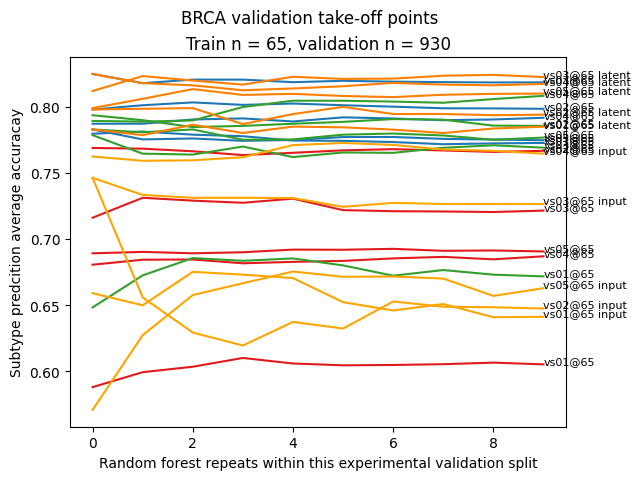

In [301]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
    plt.annotate(run, (9, inpt_val[run][9]),
                  fontsize = 8,
                  # ha = 'center'
                 )
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)    
for run in dec_val.columns:
    plt.plot(dec_val[run], color = plt.cm.Paired(3), label = run)
    plt.annotate(run, (9, dec_val[run][9]), fontsize = 8)
for run in synth_lat_val.columns:
    plt.plot(synth_lat_val[run], color = plt.cm.Paired(7), label = run)
    plt.annotate(run+' latent', (9, synth_lat_val[run][9]), fontsize = 8)
for run in synth_inpt_val.columns:
    plt.plot(synth_inpt_val[run], color = 'orange', label = run)    
    plt.annotate(run+' input', (9, synth_inpt_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' validation take-off points')
plt.title('Train n = '+str(
    len(trn))+', validation n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
# plt.legend()
plt.savefig('i_o/'+v+'/'+fine_tune_file.index.name+'/take-off_points/'+
            fine_tune_file.index.name+'_trn.'+str(len(trn))+'_input+latent+decoded+synthLat+synthInp_repeats.'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

## L. curve

In [ ]:
# Design notes - add the red curve - done, 'latent' data phase
# 75 ceiling on red, green, and blue
# 75 floor on the synthetic
    # the synthetic is orange and also blends

In [ ]:
# When building a learning curve, predict on entire validation - current
# or subset of validation frame (?) (See note on balancing sample counts within subtypes
    # from earlier

In [85]:
resmpl_count = 35 # number of times to repeat random sampling at each sample step size
    # This is learning curve resampling at each sample step size
    
    # Could define this super early on for shell script conversion

In [86]:
resmpl_count

35

In [ ]:
# Operating instructions:
    # Toggle-in each of four objects to the dataframe-to-classify variable
        # Toggle the sample count floor / ceiling in the function - in/dec vs synth.lat/synth.in
        # saving the accrcy frm into a unique object each time
    # Run seperate box production functions for the latent production
        # Find the sixth object - 

In [302]:
df_to_clf = trn # Fail without a ceiling (input), to BLUE
d_phs = 'input'
toggle_check = 'input done'
curve_range = list(range(10, trn_size+1, 5))

In [305]:
df_to_clf = decoded_labeled
d_phs = 'decoded'
toggle_check = 'decoded done'
curve_range = list(range(10, trn_size+1, 5))

In [211]:
outer_limits = 301

In [308]:
df_to_clf = synth_lat_dec
d_phs = 'lat_synth'
toggle_check = 'synthetic from latent done'
curve_range = list(range(trn_size, outer_limits, 10))

In [311]:
df_to_clf = synth_input_decoded
d_phs = 'inpt_synth'
toggle_check = 'synthetic from input done'
curve_range = list(range(trn_size, outer_limits, 10))

In [312]:
# Produce box_curve_frame
accuracy_curve_frame = pd.DataFrame() # to concat zone
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]

for smp_sz in curve_range: # Step range 2

    step_frame = pd.DataFrame()
    print(smp_sz)

    RF_output = []
    for r in list(range(0, resmpl_count)): # 35 resamplings at each step size
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz) # df_to_clf set as decoded object now, not the input
        X_trn = labeled_sample_subset_frame.iloc[:, 1:]
        y_trn = labeled_sample_subset_frame.iloc[:, 0]

        clf_trn = RandomForestClassifier()
        clf_trn.fit(X_trn, y_trn)
        
        raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))

        RF_output.append(raw_acc)
    
    step_frame['data_phase'] = [d_phs] * resmpl_count
    
    step_frame['step_size'] = [smp_sz] * resmpl_count
    step_frame['Accuracy'] = RF_output
    accuracy_curve_frame = pd.concat( [accuracy_curve_frame, step_frame] , axis = 0)    
    
print(toggle_check)

65
75
85
95
105
115
125
135
145
155
165
175
185
195
205
215
225
235
245
255
265
275
285
295
synthetic from input done


In [304]:
input_bx_crv = accuracy_curve_frame

In [307]:
decoded_bx_crv = accuracy_curve_frame

In [310]:
lat_synth_bx_crv = accuracy_curve_frame

In [313]:
inpt_synth_bx_crv = accuracy_curve_frame

## Check out

In [314]:
input_bx_crv.head(1)

,data_phase,step_size,Accuracy
0,input,10,0.576344


In [315]:
decoded_bx_crv.head(1)

,data_phase,step_size,Accuracy
0,decoded,10,0.686022


In [316]:
lat_synth_bx_crv.head(1)

,data_phase,step_size,Accuracy
0,lat_synth,65,0.767742


In [317]:
inpt_synth_bx_crv.head(1) # Could add replicates tag as column or direct to label (?)

,data_phase,step_size,Accuracy
0,inpt_synth,65,0.68172


## Latent Learning curve  
This takes the decoded validation

In [318]:
# Produce box_curve_frame, no variable toggles
d_phs = 'latent'
toggle_check = 'latent done'
accuracy_curve_frame = pd.DataFrame() # to concat zone
X_val = val_encoded_labeled.iloc[:, 1:]
y_val = val_encoded_labeled.iloc[:, 0]
for smp_sz in list(range(10, trn_size+1, 5)): # Validation threshold
    step_frame = pd.DataFrame()
    print(smp_sz)

    RF_output = []
    for r in list(range(0, resmpl_count)): # 35 resamplings at each step size
        
        labeled_sample_subset_frame = latent_object.sample(smp_sz) # df_to_clf direct set as latent object
        X_trn = labeled_sample_subset_frame.iloc[:, 1:]
        y_trn = labeled_sample_subset_frame.iloc[:, 0]

        clf_trn = RandomForestClassifier()
        clf_trn.fit(X_trn, y_trn)
        
        raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))

        RF_output.append(raw_acc)
    
    step_frame['data_phase'] = [d_phs] * resmpl_count
    
    step_frame['step_size'] = [smp_sz] * resmpl_count
    step_frame['Accuracy'] = RF_output
    accuracy_curve_frame = pd.concat( [accuracy_curve_frame, step_frame] , axis = 0)    
latent_bx_crv = accuracy_curve_frame    
print(toggle_check)

10
15
20
25
30
35
40
45
50
55
60
65
latent done


In [319]:
latent_bx_crv.head(1)

,data_phase,step_size,Accuracy
0,latent,10,0.482796


## Blend zone

In [ ]:
# Okay, blend the synth-from-latent with the input

In [114]:
trn.shape

(65, 5001)

In [172]:
synth_lat_dec.shape

(325, 5001)

In [320]:
blend_to_clf = pd.concat([trn, synth_lat_dec],
                        axis = 0)
blend_to_clf.shape

(390, 5001)

In [275]:
# Blend predictions, to box curve
d_phs = 'blend_inp/synth.frm.ltnt'
toggle_check = 'blender done'
accuracy_curve_frame = pd.DataFrame() # to concat zone
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]
for smp_sz in list(range(trn_size, outer_limits, 5)): # Synth from latent and input
    step_frame = pd.DataFrame()
    print(smp_sz)

    RF_output = []
    for r in list(range(0, resmpl_count)): # 35 resamplings at each step size
        
        labeled_sample_subset_frame = blend_to_clf.sample(smp_sz) # df_to_clf MANUAL TOGGLE function
        X_trn = labeled_sample_subset_frame.iloc[:, 1:]
        y_trn = labeled_sample_subset_frame.iloc[:, 0]

        clf_trn = RandomForestClassifier()
        clf_trn.fit(X_trn, y_trn)
        
        raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))

        RF_output.append(raw_acc)
    
    step_frame['data_phase'] = [d_phs] * resmpl_count
    
    step_frame['step_size'] = [smp_sz] * resmpl_count
    step_frame['Accuracy'] = RF_output
    accuracy_curve_frame = pd.concat( [accuracy_curve_frame, step_frame] , axis = 0)    
blend1_bx_crv = accuracy_curve_frame    
print(toggle_check)

75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
blender done


In [ ]:
blend1_bx_crv.shape # expecting slightly less in repv 5 due to synth curves stepping at ten

In [226]:
blend1_bx_crv.shape

(1610, 3)

## Line curve

In [276]:
box_curve_frame = pd.concat(
    [input_bx_crv,
     latent_bx_crv,
     decoded_bx_crv,
     
     lat_synth_bx_crv,
     inpt_synth_bx_crv,
    blend1_bx_crv] ,
    axis = 0)

In [178]:
box_curve_frame.data_phase.unique()

array(['input', 'latent', 'decoded', 'lat_synth', 'inpt_synth',
       'blend_inp/synth.frm.ltnt'], dtype=object)

/var/folders/5v/88tvwqd94gs4dfr3h6rt1_w0qd13bg/T/ipykernel_49528/2076238296.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=-55,


vs04@65 done


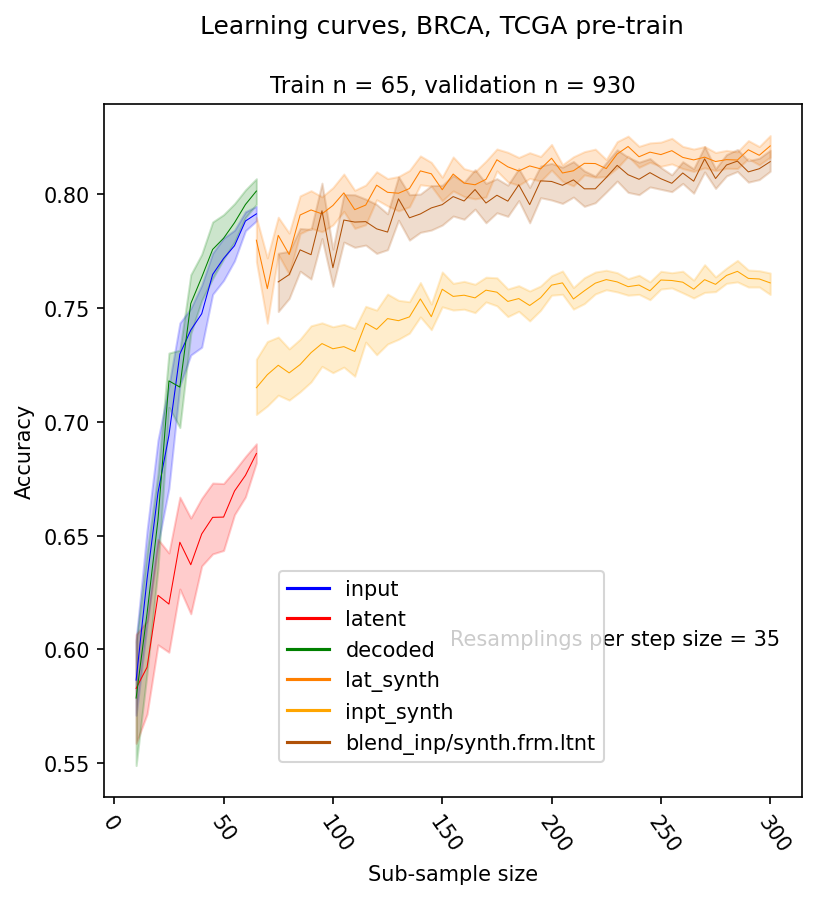

In [277]:
# Blended box curve
figure(figsize=(6, 6), dpi=150)
palette=['blue', 'red','green',
         plt.cm.Paired(7), 'orange', '#b05107']

phase_list = ['input', 'latent', 'decoded',
              'lat_synth', 'inpt_synth', 'blend_inp/synth.frm.ltnt']

ax = sns.lineplot(x='step_size', y='Accuracy',
            hue='data_phase', palette=palette,
            data=box_curve_frame, linewidth = .5)
    
plt.suptitle('Learning curves, '+trn.index.name+', TCGA pre-train')
plt.title('Train n = '+str(len(trn))+', validation n = '+str(len(val)), fontsize = 11) # across or within cohorts
plt.ylabel('Accuracy')
plt.xlabel('Sub-sample size')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.5, .3), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.legend(loc=(.25,.05))
ax.set_xticklabels(ax.get_xticklabels(),rotation=-55,
                   ha='left',
                   rotation_mode='anchor'
                  )
plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/learn_curve/'+fine_tune_file.index.name+'_learning_curve_with_TCGA_pretrain_'+str(
    repeats)+'_'+val_split+'_line.png', bbox_inches = 'tight')
print(val_split+' done')

## bx crv tmplt

In [ ]:
ax = sns.boxplot(x='step_size', y='Accuracy',
            hue='data_phase', palette=palette,
            data=box_curve_frame, linewidth = .5)

## bx crv archive

In [ ]:
# for pal_idx, phase in enumerate(phase_list):
#     phase_frame = box_curve_frame[box_curve_frame.data_phase == phase]
#     mean_list = []
#     step_list = []
#     for step_size in phase_frame.step_size.unique():
#         mean_list.append(mean(phase_frame[phase_frame.step_size == step_size].Accuracy))
#         step_list.append(step_size)
#     sns.plot(step_list, mean_list, color = palette[pal_idx])

In [ ]:
box_curve_frame = pd.concat(
    [input_bx_crv,
     decoded_bx_crv,
     lat_synth_bx_crv,
     inpt_synth_bx_crv] , axis = 0)

In [80]:
box_curve_frame.data_phase.unique()#tmplt

array(['input', 'decoded', 'lat_synth', 'inpt_synth'], dtype=object)

In [66]:
box_curve_frame

,data_phase,step_size,Accuracy
0,input,10,0.596774
1,input,10,0.493548
2,input,10,0.705376
3,input,10,0.537634
4,input,10,0.551613
...,...,...,...
30,inpt_synth,150,0.544086
31,inpt_synth,150,0.541935
32,inpt_synth,150,0.577419
33,inpt_synth,150,0.543011


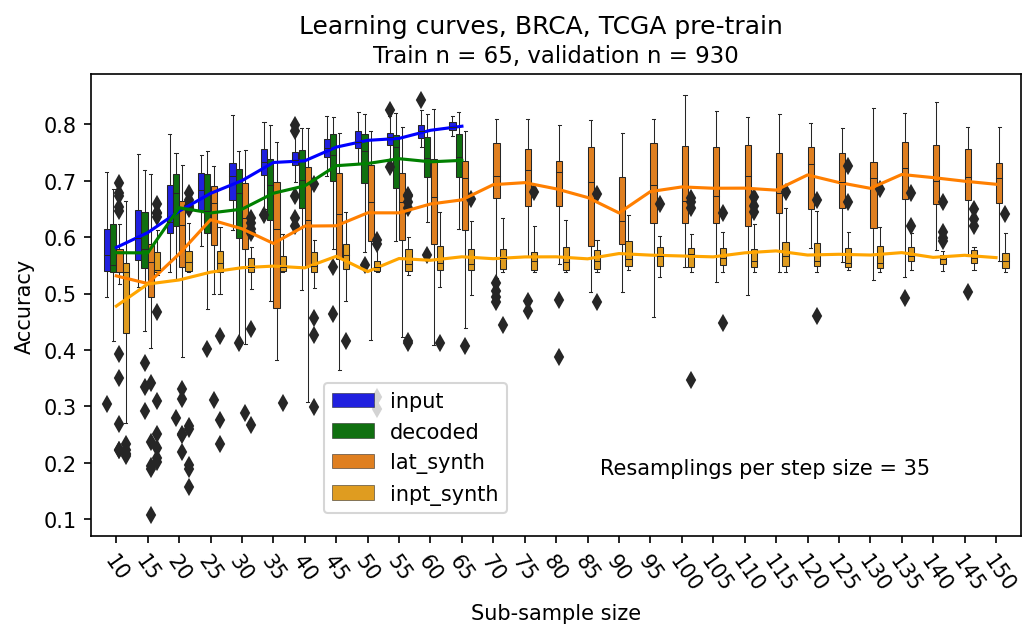

In [67]:
# Box curve, hue on data_phase column (TEMPLATE)
figure(figsize=(6, 6), dpi=150)
palette=['blue','green', plt.cm.Paired(7), 'orange']
ax = sns.boxplot(x='step_size', y='Accuracy',
            hue='data_phase', palette=palette,
            data=box_curve_frame, linewidth = .5)
phase_list = ['input', 'decoded', 'lat_synth', 'inpt_synth']

for pal_idx, phase in enumerate(phase_list):
    phase_frame = box_curve_frame[box_curve_frame.data_phase == phase]
    mean_list = []
    for step_size in phase_frame.step_size.unique():
        mean_list.append(mean(phase_frame[phase_frame.step_size == step_size].Accuracy))
        
    plt.plot(mean_list, color = palette[pal_idx])
plt.suptitle('Learning curves, '+trn.index.name+', TCGA pre-train')
plt.title('Train n = '+str(len(trn))+', validation n = '+str(len(val)), fontsize = 11) # across or within cohorts
plt.ylabel('Accuracy')
plt.xlabel('Sub-sample size')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.5, .3), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.legend(loc=(.25,.05))
ax.set_xticklabels(ax.get_xticklabels(),rotation=-55,
                   ha='left',
                   rotation_mode='anchor'
                  )
plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'/learn_curve/'+fine_tune_file.index.name+'_learning_curve_with_TCGA_pretrain_'+str(
    repeats)+'_'+val_split+'.png', bbox_inches = 'tight')

In [ ]:
plt.annotate('Synthetic data ratio: 200%',
                xy=(.45, .35), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )

## Front-end box

In [189]:
inpt_summ = pd.DataFrame(data = inpt_val.iloc[9,:])
inpt_summ.insert(0, 'Take-off_point', 'input')

In [190]:
dec_summ = pd.DataFrame(data = dec_val.iloc[9,:])
dec_summ.insert(0, 'Take-off_point', 'decoded')

In [191]:
syn_lat_summ = pd.DataFrame(data = synth_lat_val.iloc[9,:])
syn_lat_summ.insert(0, 'Take-off_point', 'latent_synth')

In [192]:
syn_inpt_summ = pd.DataFrame(data = synth_inpt_val.iloc[9,:])
syn_inpt_summ.insert(0, 'Take-off_point', 'input_synth')

In [193]:
summ = pd.concat([inpt_summ, dec_summ, syn_lat_summ, syn_inpt_summ])

In [194]:
summ

,Take-off_point,9
vs04,input,0.979496
vs03,input,0.969424
vs02,input,0.970504
vs01,input,0.959712
vs00,input,0.970144
vs04,decoded,0.976259
vs03,decoded,0.970504
vs02,decoded,0.973381
vs01,decoded,0.960072
vs00,decoded,0.967626


In [195]:
summ.columns = ['Take-off_point', 'Accuracy']

In [ ]:
# Plot the front-end model performance
# This is how to gauge the quality of the input to the learning curve

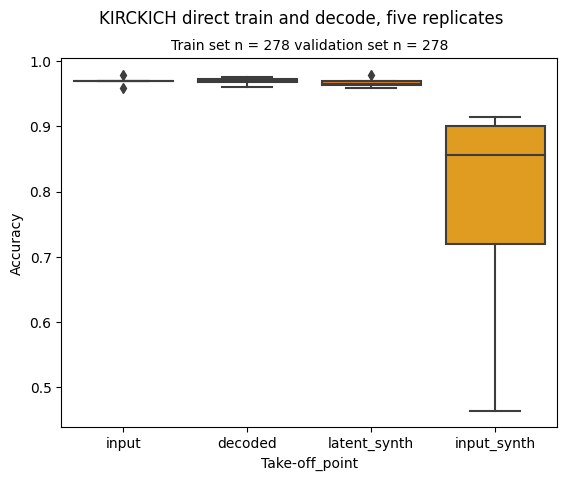

In [196]:
my_pal = {'input': plt.cm.Paired(1),
          'decoded': plt.cm.Paired(3),
          'latent_synth': plt.cm.Paired(7),
          'input_synth': 'orange'}

# figure(figsize=(8, 4), dpi=150)
ax = sns.boxplot(summ, x='Take-off_point', y='Accuracy',
           palette = my_pal)

# add_stat_annotation(ax,
#                     data=summ,
#                     x='Take-off_point',
#                     y='Accuracy',
#                     # order=order,
#                     box_pairs=[('input', 'decoded'),
#                               ('input', 'latent_synth'),
#                               ('input', 'input_synth')
#                               ],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=0)

plt.suptitle(trn.index.name+' direct train and decode, five replicates')
plt.title('Train set n = '+str(len(trn))+' validation set n = '+str(len(val)),
         fontsize = 10)
plt.savefig('i_o/'+v+'/'+trn.index.name+'_front_end_direct_'+str(
    repeats)+'_'+val_split+'_repeats.png', bbox_inches = 'tight')